<a href="https://colab.research.google.com/github/eoinleen/Protein-design-random/blob/main/Buried_surface_area_plot_attempt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing /content/drive/MyDrive/PDB-files/all_pdb-2MBO-no-hot/design0_n16.pdb
Chain IDs: ['A', 'B']
Total Area: 13049.52 Å^2
Chain A Area: 8650.63 Å^2
Chain B Area: 6303.04 Å^2
Pairwise Buried Surface Areas for design0_n16.pdb: {('A', 'B'): 1904.1513178070472}
Total Buried Surface Area for design0_n16.pdb: Not applicable
Processing /content/drive/MyDrive/PDB-files/all_pdb-2MBO-no-hot/design0_n13.pdb
Chain IDs: ['A', 'B']
Total Area: 12855.60 Å^2
Chain A Area: 7783.83 Å^2
Chain B Area: 6416.56 Å^2
Pairwise Buried Surface Areas for design0_n13.pdb: {('A', 'B'): 1344.7947755508903}
Total Buried Surface Area for design0_n13.pdb: Not applicable
Processing /content/drive/MyDrive/PDB-files/all_pdb-2MBO-no-hot/design0_n1.pdb
Chain IDs: ['A', 'B']
Total Area: 12573.78 Å^2
Chain A Area: 7622.58 Å^2
Chain B Area: 6544.95 Å^2
Pairwise Buried Surface Areas for design0_n1.pdb: {('A', 'B'): 1593.746527033214}
Total Buried Surface Area for design0_n1.pdb: Not applicable
Processing /content/drive/MyD

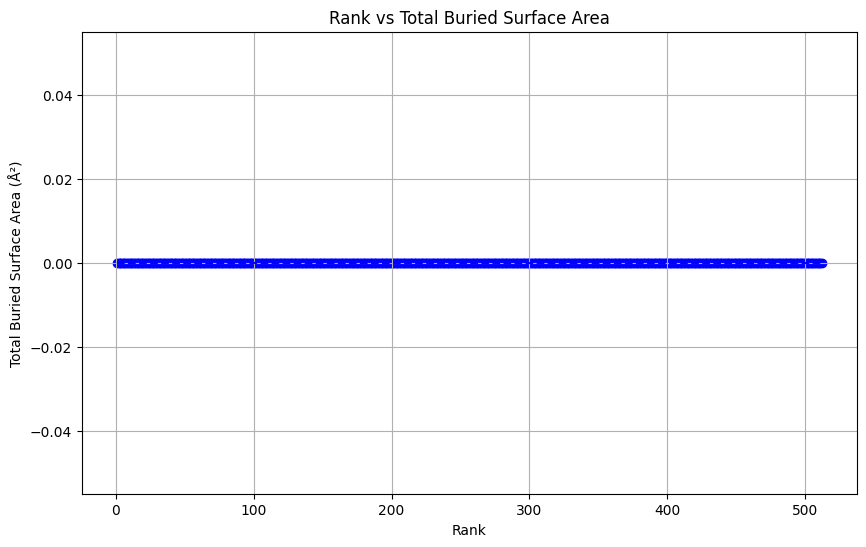

In [9]:
# Install the required libraries
!pip install biopython freesasa matplotlib

# Import the necessary modules
import os
import freesasa
import matplotlib.pyplot as plt
from Bio import PDB
from Bio.PDB.PDBIO import PDBIO

# Define the function to calculate buried surface area
def calculate_buried_surface_area(pdb_file):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)

    chains = [chain for chain in structure.get_chains()]
    if len(chains) not in [2, 3]:
        raise ValueError("PDB file must contain exactly 2 or 3 chains")

    chain_ids = [chain.id for chain in chains]
    print(f"Chain IDs: {chain_ids}")

    # Write each chain to separate PDB files
    io = PDBIO()
    chain_files = []
    for chain in chains:
        chain_file = f"chain_{chain.id}.pdb"
        io.set_structure(chain)
        io.save(chain_file)
        chain_files.append(chain_file)

    # Calculate the surface area of the combined structure
    combined_structure = freesasa.Structure(pdb_file)
    result = freesasa.calc(combined_structure)
    total_area = result.totalArea()
    print(f"Total Area: {total_area:.2f} Å^2")

    # Calculate the surface areas of individual chains
    chain_areas = []
    for chain_file in chain_files:
        chain_structure = freesasa.Structure(chain_file)
        chain_result = freesasa.calc(chain_structure)
        chain_area = chain_result.totalArea()
        chain_areas.append(chain_area)
        print(f"Chain {chain_file[-5]} Area: {chain_area:.2f} Å^2")

    # Calculate buried surface areas for each pair of chains
    pairwise_buried_surface_areas = {}
    for i in range(len(chains)):
        for j in range(i + 1, len(chains)):
            combined_pdb_content = ''
            with open(chain_files[i], 'r') as file:
                combined_pdb_content += file.read()
            with open(chain_files[j], 'r') as file:
                combined_pdb_content += file.read()

            combined_pdb_file = f'combined_{chain_ids[i]}_{chain_ids[j]}.pdb'
            with open(combined_pdb_file, 'w') as file:
                file.write(combined_pdb_content)

            combined_structure = freesasa.Structure(combined_pdb_file)
            combined_result = freesasa.calc(combined_structure)
            combined_area = combined_result.totalArea()
            pairwise_buried_surface_area = combined_area - (chain_areas[i] + chain_areas[j])
            pairwise_buried_surface_areas[(chain_ids[i], chain_ids[j])] = abs(pairwise_buried_surface_area)

    # Calculate the total buried surface area if there are 3 chains
    total_buried_surface_area = None
    if len(chains) == 3:
        total_buried_surface_area = total_area - sum(chain_areas)
        total_buried_surface_area = abs(total_buried_surface_area)

    return pairwise_buried_surface_areas, total_buried_surface_area

# Function to add a header to the PDB file
def add_header_to_pdb(pdb_file, header_text):
    with open(pdb_file, 'r') as file:
        content = file.read()

    with open(pdb_file, 'w') as file:
        file.write(f"HEADER    {header_text}\n")
        file.write(content)

# Process multiple PDB files
def process_multiple_pdb_files(pdb_directory):
    bsa_results = []

    for file_name in os.listdir(pdb_directory):
        if file_name.endswith(".pdb"):
            pdb_file = os.path.join(pdb_directory, file_name)
            print(f"Processing {pdb_file}")

            try:
                pairwise_buried_surface_areas, total_buried_surface_area = calculate_buried_surface_area(pdb_file)
                bsa_results.append((file_name, pairwise_buried_surface_areas, total_buried_surface_area))
                print(f"Pairwise Buried Surface Areas for {file_name}: {pairwise_buried_surface_areas}")
                if total_buried_surface_area is not None:
                    print(f"Total Buried Surface Area for {file_name}: {total_buried_surface_area:.2f} Å^2")
                else:
                    print(f"Total Buried Surface Area for {file_name}: Not applicable")

                # Add header to the PDB file
                header_text = "Built by Microsoft Copilot with help from the user"
                add_header_to_pdb(pdb_file, header_text)

            except Exception as e:
                print(f"Error processing {pdb_file}: {e}")

    return bsa_results

# Provide the path to your directory containing PDB files
pdb_directory = '/content/drive/MyDrive/PDB-files/all_pdb-2MBO-no-hot'  # Update this path to the location of your PDB files

# Process the PDB files and compile the results
bsa_results = process_multiple_pdb_files(pdb_directory)

# Sort results based on total buried surface area in descending order
sorted_bsa_results = sorted(bsa_results, key=lambda x: x[2] if x[2] is not None else 0, reverse=True)

# Generate summary report
print("\nSummary Report:")
print(f"{'PDB File':<30} {'Pairwise Buried Surface Areas (Å²)':<40} {'Total Buried Surface Area (Å²)'}")
print("="*90)
for file_name, pairwise_bsa, total_bsa in sorted_bsa_results:
    if total_bsa is not None:
        print(f"{file_name:<30} {pairwise_bsa} {total_bsa:.2f}")
    else:
        print(f"{file_name:<30} {pairwise_bsa} Not applicable")

# Generate scatter plot
ranks = list(range(1, len(sorted_bsa_results) + 1))
total_bsa_values = [total_bsa if total_bsa is not None else 0 for _, _, total_bsa in sorted_bsa_results]

plt.figure(figsize=(10, 6))
plt.scatter(ranks, total_bsa_values, color='blue')
plt.plot(ranks, total_bsa_values, color='blue', linestyle='--')
plt.xlabel('Rank')
plt.ylabel('Total Buried Surface Area (Å²)')
plt.title('Rank vs Total Buried Surface Area')
plt.grid(True)
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')